In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install plotly ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29411 sha256=5b4a991284c509f6544c22304f06bd7ea670ad1561dc0db2cc8a68ea3f5e0f67
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
import ta
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
import joblib
from datetime import datetime, timedelta

In [5]:
# Recopilación de Datos
sp500_ticker = "MES=F"
start_date = "2020-05-25"
end_date = "2024-06-24"

sp500_data = yf.download(sp500_ticker, start=start_date, end=end_date)
sp500_close_volume = sp500_data[["Open", "High", "Low", 'Close', 'Volume']]
vix_data = yf.download("^VIX", start=start_date, end=end_date)
""""
# Establecer un valor específico para 'Close' y 'Volume' en las dos última fecha
last_index = sp500_close_volume.index[-2]  # Obtiene el último índice
sp500_close_volume.at[last_index, 'Open'] = 5299.25
sp500_close_volume.at[last_index, 'High'] = 5315.00
sp500_close_volume.at[last_index, 'Low'] = 5246.75
sp500_close_volume.at[last_index, 'Close'] = 5297.25
sp500_close_volume.at[last_index, 'Volume'] = 1078000

last_index = sp500_close_volume.index[-1]  # Obtiene el último índice
sp500_close_volume.at[last_index, 'Open'] = 5300.00
sp500_close_volume.at[last_index, 'High'] = 5312.25
sp500_close_volume.at[last_index, 'Low'] = 5262.00
sp500_close_volume.at[last_index, 'Close'] = 5304.00
sp500_close_volume.at[last_index, 'Volume'] = 1003000

# Ingeniería de Características
#sp500_close_volume['EMA_20'] = ta.trend.EMAIndicator(sp500_close_volume['Close'], window=20).ema_indicator()
sp500_close_volume['SMA_10'] = ta.trend.SMAIndicator(sp500_close_volume['Close'], window=10).sma_indicator()
sp500_close_volume['SMA_5'] = ta.trend.SMAIndicator(sp500_close_volume['Close'], window=5).sma_indicator()
sp500_close_volume['RSI_14'] = ta.momentum.RSIIndicator(sp500_close_volume['Close'], window=14).rsi()
sp500_close_volume['CCI'] = ta.trend.CCIIndicator(sp500_close_volume['High'], sp500_close_volume['Low'], sp500_close_volume['Close'], window=14).cci()
sp500_close_volume['ATR'] = ta.volatility.AverageTrueRange(sp500_close_volume['High'], sp500_close_volume['Low'], sp500_close_volume['Close'], window=14).average_true_range()
sp500_close_volume['VIX'] = vix_data[['Close']]
"""
# Guardar el DataFrame sp500_close_volume como CSV en la ruta especificada
csv_path_sp500 = '/content/drive/My Drive/UTN/2024/202401/1_Investigacion/2024/IA_FIN_5_ANOS/Fuentes/Articulos/3/20240621_entrada_v81.csv'
sp500_close_volume.to_csv(csv_path_sp500, index=True)

sp500_close_volume

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Open     High      Low        Close   Volume
Date                                                       
2020-05-26  2948.75  3019.75  2947.75  2994.500000  1023998
2020-05-27  2994.25  3039.75  2965.50  3035.500000  1168154
2020-05-28  3034.50  3065.50  3019.50  3038.000000   958717
2020-05-29  3036.00  3058.50  2992.25  3042.000000  1176313
2020-06-01  3032.00  3058.75  3007.75  3054.000000   714753
...             ...      ...      ...          ...      ...
2024-06-14  5436.25  5443.00  5397.75  5437.500000   744598
2024-06-17  5435.50  5494.00  5424.75  5478.500000   229630
2024-06-18  5481.75  5494.00  5473.75  5491.000000   120953
2024-06-20  5492.25  5518.50  5458.50  5476.750000   182705
2024-06-21  5478.25  5484.00  5460.00  5471.890137   182705

[1027 rows x 5 columns]

In [6]:
# Eliminar NaNs
sp500_clean = sp500_close_volume.dropna()

# Escalar los datos antes de aplicar PCA
scaler = MinMaxScaler()
sp500_scaled = scaler.fit_transform(sp500_clean)

# Análisis de Componentes Principales (PCA)
c = 2 #Componentes
pca = PCA(n_components=c)
pca_result = pca.fit_transform(sp500_scaled)
pca_df = pd.DataFrame(data=pca_result, columns=[f'Principal Component {i+1}' for i in range(c)], index=sp500_clean.index)

In [7]:
# División Temporal de Datos
train_size = int(len(pca_df) * 0.6)
val_size = int(len(pca_df) * 0.2)
test_size = len(pca_df) - train_size - val_size

X_train = pca_df.iloc[:train_size]
y_train = sp500_clean['Close'].iloc[:train_size]
X_val = pca_df.iloc[train_size:train_size + val_size]
y_val = sp500_clean['Close'].iloc[train_size:train_size + val_size]
X_test = pca_df.iloc[train_size + val_size:]
y_test = sp500_clean['Close'].iloc[train_size + val_size:]

# Escalador para la variable objetivo
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

In [8]:
# Crear secuencias para LSTM
def create_sequences(data, target, window_size=1):
    xs = []
    ys = []
    for i in range(len(data) - window_size):
        x = data[i:(i + window_size)]
        y = target[i + window_size]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

window_size = 1
X_train_seq, y_train_seq = create_sequences(X_train.values, y_train_scaled.flatten(), window_size)
X_val_seq, y_val_seq = create_sequences(X_val.values, y_val_scaled.flatten(), window_size)
X_test_seq, y_test_seq = create_sequences(X_test.values, y_test_scaled.flatten(), window_size)

# Definir el modelo LSTM
def build_model(input_shape):
    model = Sequential([
        LSTM(50, input_shape=input_shape, return_sequences=True),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Configurar el callback de Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0005, patience=30, verbose=1, mode='min', restore_best_weights=True)

Restoring model weights from the end of the best epoch: 10.
Epoch 40: early stopping


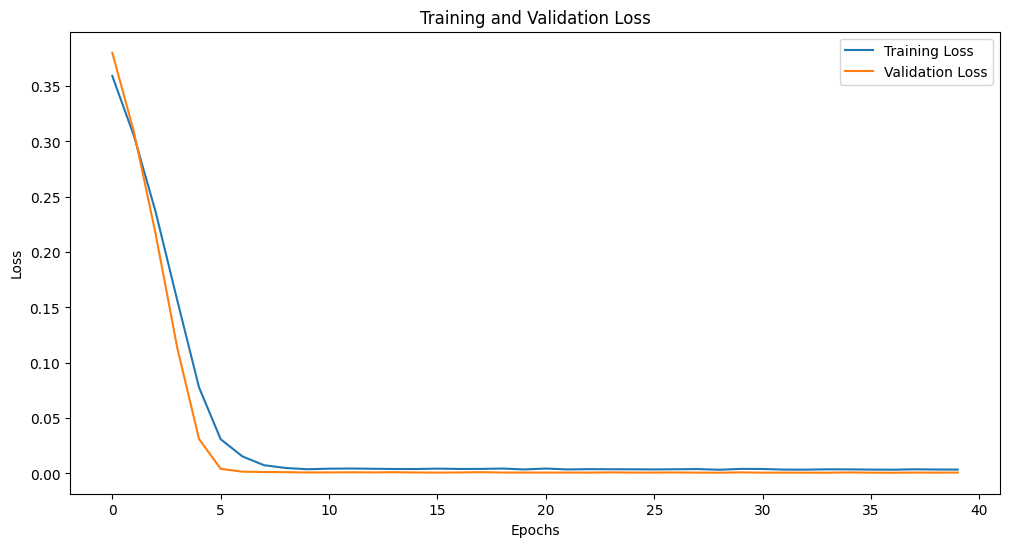

In [9]:
# Entrenar modelo con los datos de entrenamiento y validación
model = build_model((window_size, X_train_seq.shape[2]))
history = model.fit(X_train_seq, y_train_seq, epochs=100, batch_size=50, verbose=0, validation_data=(X_val_seq, y_val_seq),
                    callbacks=[early_stopping])

# Gráfico de pérdida para entrenamiento y validación
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [10]:
# Guardar el modelo entrenado en un archivo con joblib
model_path = '/content/drive/My Drive/UTN/2024/202401/1_Investigacion/2024/IA_FIN_5_ANOS/Fuentes/Articulos/3/20240621_trained_model_v81.pkl'
joblib.dump(model, model_path)

['/content/drive/My Drive/UTN/2024/202401/1_Investigacion/2024/IA_FIN_5_ANOS/Fuentes/Articulos/3/20240621_trained_model_v81.pkl']

In [11]:
# Cargar el modelo entrenado desde el archivo
#model_path = '/content/drive/My Drive/UTN/2024/202401/1_Investigacion/2024/IA_FIN_5_ANOS/Fuentes/Articulos/3/20240529_trained_model_v8.pkl'
#model = joblib.load(model_path)

# Walk-Forward Validation solo con los datos de prueba
actuals = []
predictions = []
test_losses = []
step_size = 1

for i in range(len(X_test_seq)):
    X_test_wfv, y_test_wfv = X_test_seq[i:i+step_size], y_test_seq[i:i+step_size]

    # Hacer predicciones para el paso actual
    preds = model.predict(X_test_wfv).flatten()
    preds_rescaled = scaler_y.inverse_transform(preds.reshape(-1, 1)).flatten()
    y_test_rescaled = scaler_y.inverse_transform(y_test_wfv.reshape(-1, 1)).flatten()

    predictions.extend(preds_rescaled)
    actuals.extend(y_test_rescaled)

    # Evaluar el modelo sobre los datos de prueba actuales y almacenar la pérdida
    test_loss = mean_squared_error(y_test_rescaled, preds_rescaled)
    test_losses.append(test_loss)

    # Actualizar el modelo con nuevos datos
    h = model.fit(X_test_wfv, y_test_wfv, epochs=50, batch_size=5, verbose=0, validation_data=(X_test_wfv, y_test_wfv),
              callbacks=[early_stopping])

    print(f"Iteración N° {i}")

1/1 [==============================] - 1s 961ms/step
Restoring model weights from the end of the best epoch: 4.
Epoch 34: early stopping
Iteración N° 0
1/1 [==============================] - 0s 63ms/step
Restoring model weights from the end of the best epoch: 4.
Epoch 34: early stopping
Iteración N° 1
1/1 [==============================] - 0s 27ms/step
Restoring model weights from the end of the best epoch: 1.
Epoch 31: early stopping
Iteración N° 2
1/1 [==============================] - 0s 22ms/step
Restoring model weights from the end of the best epoch: 1.
Epoch 31: early stopping
Iteración N° 3
1/1 [==============================] - 0s 25ms/step
Restoring model weights from the end of the best epoch: 7.
Epoch 37: early stopping
Iteración N° 4
1/1 [==============================] - 0s 28ms/step
Restoring model weights from the end of the best epoch: 1.
Epoch 31: early stopping
Iteración N° 5
1/1 [==============================] - 0s 25ms/step
Restoring model weights from the end of t

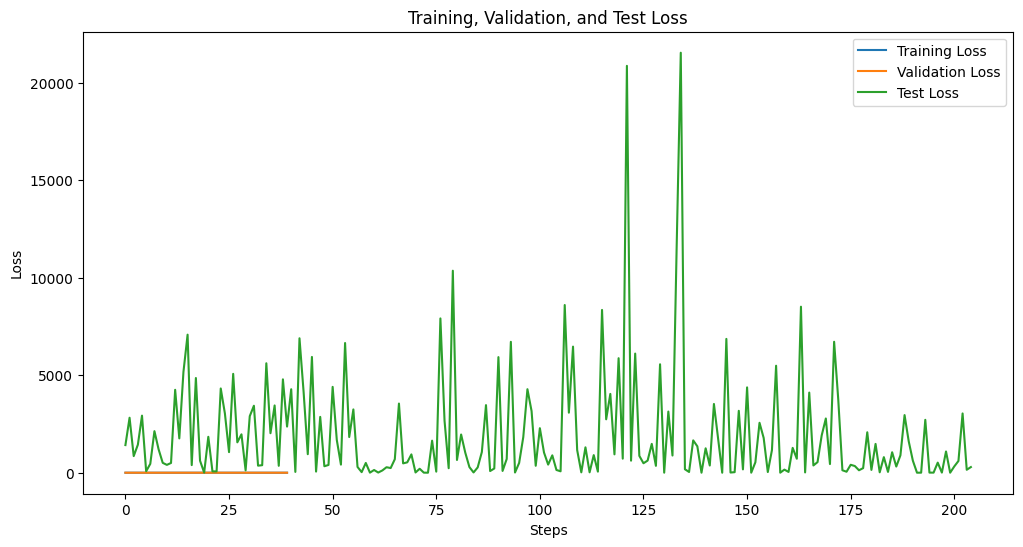

In [12]:
# Gráfico de pérdida para entrenamiento, validación y prueba
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(range(len(test_losses)), test_losses, label='Test Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Loss')
plt.legend()
plt.show()

In [13]:
# Eliminar el primer valor del índice
y_test_index_modified = y_test.index[1:]  # Esto elimina el primer valor del índice
results_df1 = pd.DataFrame({'Actual': actuals, 'Predicted': predictions}, y_test_index_modified)
last_date = results_df1.index[-1]
next_date = last_date + timedelta(days=1)
extended_index = y_test_index_modified.tolist() + [next_date]

In [14]:
# Predicción para el siguiente día después del último día disponible
last_sequence = X_test_seq[-window_size:].reshape(1, window_size, X_test_seq.shape[2])
next_step_prediction = model.predict(last_sequence).flatten()[0]
next_step_prediction_rescaled = scaler_y.inverse_transform(np.array([next_step_prediction]).reshape(-1, 1)).flatten()[0]
print("La predicción para el siguiente día es:", next_step_prediction_rescaled)
predictions.append(next_step_prediction_rescaled)  # Agregar predicción
actuals.append(actuals[-1])  # Repetir el último valor real para alinear con la predicción futura
results_df = pd.DataFrame({'Actual': actuals, 'Predicted': predictions}, extended_index)
results_df

1/1 [==============================] - 0s 23ms/step
La predicción para el siguiente día es: 5450.222


Actual    Predicted
2023-08-30  4524.250000  4486.604980
2023-08-31  4516.000000  4569.103027
2023-09-01  4521.500000  4550.685547
2023-09-05  4502.500000  4540.394043
2023-09-06  4471.500000  4525.605469
...                 ...          ...
2024-06-17  5478.500000  5453.943848
2024-06-18  5491.000000  5435.863770
2024-06-20  5476.750000  5464.455078
2024-06-21  5471.890137  5454.848145
2024-06-22  5471.890137  5450.222168

[206 rows x 2 columns]

In [30]:
# Visualizar los resultados
fig = go.Figure()

fig.add_trace(go.Scatter(x=results_df.index, y=results_df['Actual'], mode='lines', name='Actual', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=results_df.index, y=results_df['Predicted'], mode='lines', name='Predicted', line=dict(dash='dash', color='red')))

# Calcular métricas para WFV
wfv_mae = mean_absolute_error(results_df['Actual'].dropna(), results_df['Predicted'].dropna())
wfv_mse = mean_squared_error(results_df['Actual'].dropna(), results_df['Predicted'].dropna())
wfv_rmse = np.sqrt(wfv_mse)
wfv_errors = np.abs(results_df['Actual'].dropna() - results_df['Predicted'].dropna())
wfv_std_dev_ae = np.std(wfv_errors)
wfv_mape = np.mean(np.abs((results_df['Actual'].dropna() - results_df['Predicted'].dropna()) / results_df['Actual'].dropna())) * 100

fig.update_layout(
    title=f'Actual vs Predicted Prices (WFV)<br>Prediction for the next day: {next_step_prediction_rescaled:.2f}<br>RMSE: {wfv_rmse:.6f}<br>MAE: {wfv_mae:.6f}<br>SD of AE: {wfv_std_dev_ae:.6f}<br>MAPE: {wfv_mape:.6f}%',
    xaxis_title='Date',
    yaxis_title='Price',
    legend_title='Legend'
)

print(f'MES: {wfv_mse:.2f}<br>RMSE: {wfv_rmse:.6f}<br>MAE: {wfv_mae:.6f}<br>SD of AE: {wfv_std_dev_ae:.6f}<br>MAPE: {wfv_mape:.6f}%')
fig.show()

MES: 1966.87<br>RMSE: 44.349411<br>MAE: 34.836473<br>SD of AE: 27.446136<br>MAPE: 0.726523%


In [16]:
# Crear una nueva columna 'DifferenceA' donde cada valor es 'Actual' - 'Actual anterior' de la fila anterior.
#results_df['DifferenceA'] = results_df['Actual'] - results_df['Actual'].shift(1)

# Crear una nueva columna 'DifferenceP' donde cada valor es 'Predicted' - 'Predicted anterior' de la fila anterior.
results_df['DifferenceP'] = results_df['Predicted']- results_df['Predicted'].shift(1)

# Crear la columna 'c1v-1' usando np.where
results_df['c1v-1'] = np.where(results_df['DifferenceP'] >= 0, 1, -1)


# Calculamos las diferencias entre el valor actual y el valor anterior de 'Actual'
results_df['Prev_Actual'] = results_df['Actual'].shift(1)
results_df['DifferenceA'] = results_df['Actual'] - results_df['Prev_Actual']

# Crear la columna 'Actual_SB' usando np.where
results_df['Actual_SB'] = np.where(results_df['DifferenceA'] >= 0, 1, -1)

# Definimos una función que evalúa las condiciones y calcula el valor de 'gan'
def calculate_gain(row):
    if row['c1v-1'] == 1:
        return row['DifferenceA']  # Si c1v-1 es 0, retorna la diferencia directamente.
    else:
        if row['Actual'] < row['Prev_Actual']:
            return -row['DifferenceA']  # Si c1v-1 es -1 y Actual es menor, retorno positivo de la diferencia.
        else:
            return -row['DifferenceA']  # Si c1v-1 es -1 y Actual es mayor, retorno negativo de la diferencia.

# Aplicamos la función para crear la columna 'G/P_P'
results_df['G/P_P'] = results_df.apply(calculate_gain, axis=1)

# Aplicamos la función para crear la columna 'G/P_D'
results_df['G/P_D'] = results_df['G/P_P'] * 5

# Eliminamos la columna auxiliar si no es necesaria
results_df.drop('Prev_Actual', axis=1, inplace=True)

# Crear la columna 'decision' basada en las condiciones especificadas
results_df['decision'] = np.where(
    ((results_df['c1v-1'] == 1) & (results_df['G/P_P'] >= 0)) |
    ((results_df['c1v-1'] == -1) & (results_df['G/P_P'] >= 0)),
    'Correcta',
    'Incorrecta'
)

# Mostrar las primeras filas del DataFrame para verificar los resultados
#print(results_df.head(5))

# Mostrar las ultimas filas del DataFrame para verificar los resultados
#print(results_df.tail(5))

# Calcular la suma total de la columna 'gan'
total_gain_P = results_df['G/P_P'].sum()
total_gain_D = results_df['G/P_D'].sum()

# Imprimir el resultado
print("La suma total de la columna 'G/P_P' es:", total_gain_P)
print("La suma total de la columna 'G/P_D' es:", total_gain_D)

results_df

La suma total de la columna 'G/P_P' es: 314.06005859375
La suma total de la columna 'G/P_D' es: 1570.30029296875


Actual    Predicted  DifferenceP  c1v-1  DifferenceA  \
2023-08-30  4524.250000  4486.604980          NaN     -1          NaN   
2023-08-31  4516.000000  4569.103027    82.498047      1    -8.250000   
2023-09-01  4521.500000  4550.685547   -18.417480     -1     5.500000   
2023-09-05  4502.500000  4540.394043   -10.291504     -1   -19.000000   
2023-09-06  4471.500000  4525.605469   -14.788574     -1   -31.000000   
...                 ...          ...          ...    ...          ...   
2024-06-17  5478.500000  5453.943848    -1.564941     -1    41.000000   
2024-06-18  5491.000000  5435.863770   -18.080078     -1    12.500000   
2024-06-20  5476.750000  5464.455078    28.591309      1   -14.250000   
2024-06-21  5471.890137  5454.848145    -9.606934     -1    -4.859863   
2024-06-22  5471.890137  5450.222168    -4.625977     -1     0.000000   

            Actual_SB      G/P_P       G/P_D    decision  
2023-08-30         -1        NaN         NaN  Incorrecta  
2023-08-31         -1  -8.250000  -41.250000  Incorrecta  
2023-09-01          1  -5.500000  -27.500000  Incorrecta  
2023-09-05         -1  19.000000   95.000000    Correcta  
2023-09-06         -1  31.000000  155.000000    Correcta  
...               ...        ...         ...         ...  
2024-06-17          1 -41.000000 -205.000000  Incorrecta  
2024-06-18          1 -12.500000  -62.500000  Incorrecta  
2024-06-20         -1 -14.250000  -71.250000  Incorrecta  
2024-06-21         -1   4.859863   24.299316    Correcta  
2024-06-22          1  -0.000000   -0.000000    Correcta  

[206 rows x 9 columns]

In [17]:
def calculate_sharpe_ratio(returns, initial_capital, risk_free_rate=0.05):
    returns = returns / initial_capital
    excess_returns = returns - risk_free_rate / 252
    return np.mean(excess_returns) / np.std(excess_returns) * np.sqrt(252)

def calculate_sortino_ratio(returns, initial_capital, risk_free_rate=0.05):
    returns = returns / initial_capital
    excess_returns = returns - risk_free_rate / 252
    negative_returns = returns[returns < 0]
    downside_deviation = np.std(negative_returns)
    return np.mean(excess_returns) / downside_deviation * np.sqrt(252)

def calculate_maximum_drawdown(returns, initial_capital):
    cumulative_returns = np.cumsum(returns) + initial_capital
    rolling_max = np.maximum.accumulate(cumulative_returns)
    drawdown = cumulative_returns / rolling_max - 1.0
    return drawdown.min()

def calculate_rate_of_return(returns, initial_capital):
    final_value = initial_capital + np.sum(returns)
    return (final_value - initial_capital) / initial_capital

def calculate_total_return(returns):
    return np.sum(returns)

In [18]:
# Supongamos que results_df es tu DataFrame que contiene la columna 'G/P_D'
# Cargar el DataFrame (asegúrate de ajustar el path a tu archivo CSV)
# results_df = pd.read_csv('path_to_your_csv_file.csv')

# Definir el capital inicial
initial_capital = 2000

# Calcular retornos diarios a partir de la columna 'G/P_D'
returns = results_df['G/P_D'].dropna().values

# Calcular Sharpe Ratio
sharpe_ratio = calculate_sharpe_ratio(returns, initial_capital)
print(f'Sharpe Ratio: {sharpe_ratio}')

# Calcular Sortino Ratio
sortino_ratio = calculate_sortino_ratio(returns, initial_capital)
print(f'Sortino Ratio: {sortino_ratio}')

# Calcular Maximum Drawdown
max_drawdown = calculate_maximum_drawdown(returns, initial_capital)
print(f'Maximum Drawdown: {max_drawdown}')

# Calcular Rate of Return
rate_of_return = calculate_rate_of_return(returns, initial_capital)
print(f'Rate of Return: {rate_of_return}')

# Calcular Total Return
total_return = calculate_total_return(returns)
print(f'Total Return: {total_return}')

Sharpe Ratio: 0.6478749231024304
Sortino Ratio: 1.0144608352520232
Maximum Drawdown: -0.6571017100412826
Rate of Return: 0.785150146484375
Total Return: 1570.30029296875


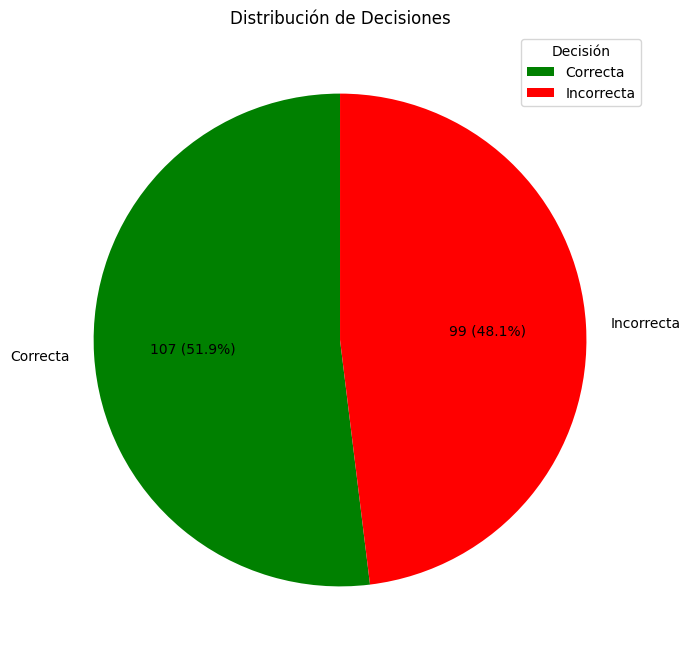

In [19]:
#Cantidad de decisiones correctas

# Recuento de entradas por categoría en la columna 'decision'
decision_counts = results_df['decision'].value_counts()

# Función para formatear las etiquetas con valores absolutos y porcentajes
def absolute_and_percent(val):
    a = int(np.round(val/100.*decision_counts.sum()))
    return f"{a} ({val:.1f}%)"

# Graficar el gráfico de pastel
plt.figure(figsize=(8, 8))  # Ajustar tamaño del gráfico
plt.pie(decision_counts, labels=decision_counts.index, autopct=absolute_and_percent, startangle=90, colors=['green', 'red'])
plt.title('Distribución de Decisiones')

# Opcional: agregar una leyenda
plt.legend(decision_counts.index, title="Decisión", loc="best")

plt.show()


In [20]:
# Agrupar por 'c1v-1' y contar las decisiones en cada grupo
grouped_decision_counts = results_df.groupby('decision')['c1v-1'].value_counts().unstack()

print(grouped_decision_counts)  # Ver los datos agrupados

c1v-1       -1   1
decision          
Correcta    45  62
Incorrecta  53  46


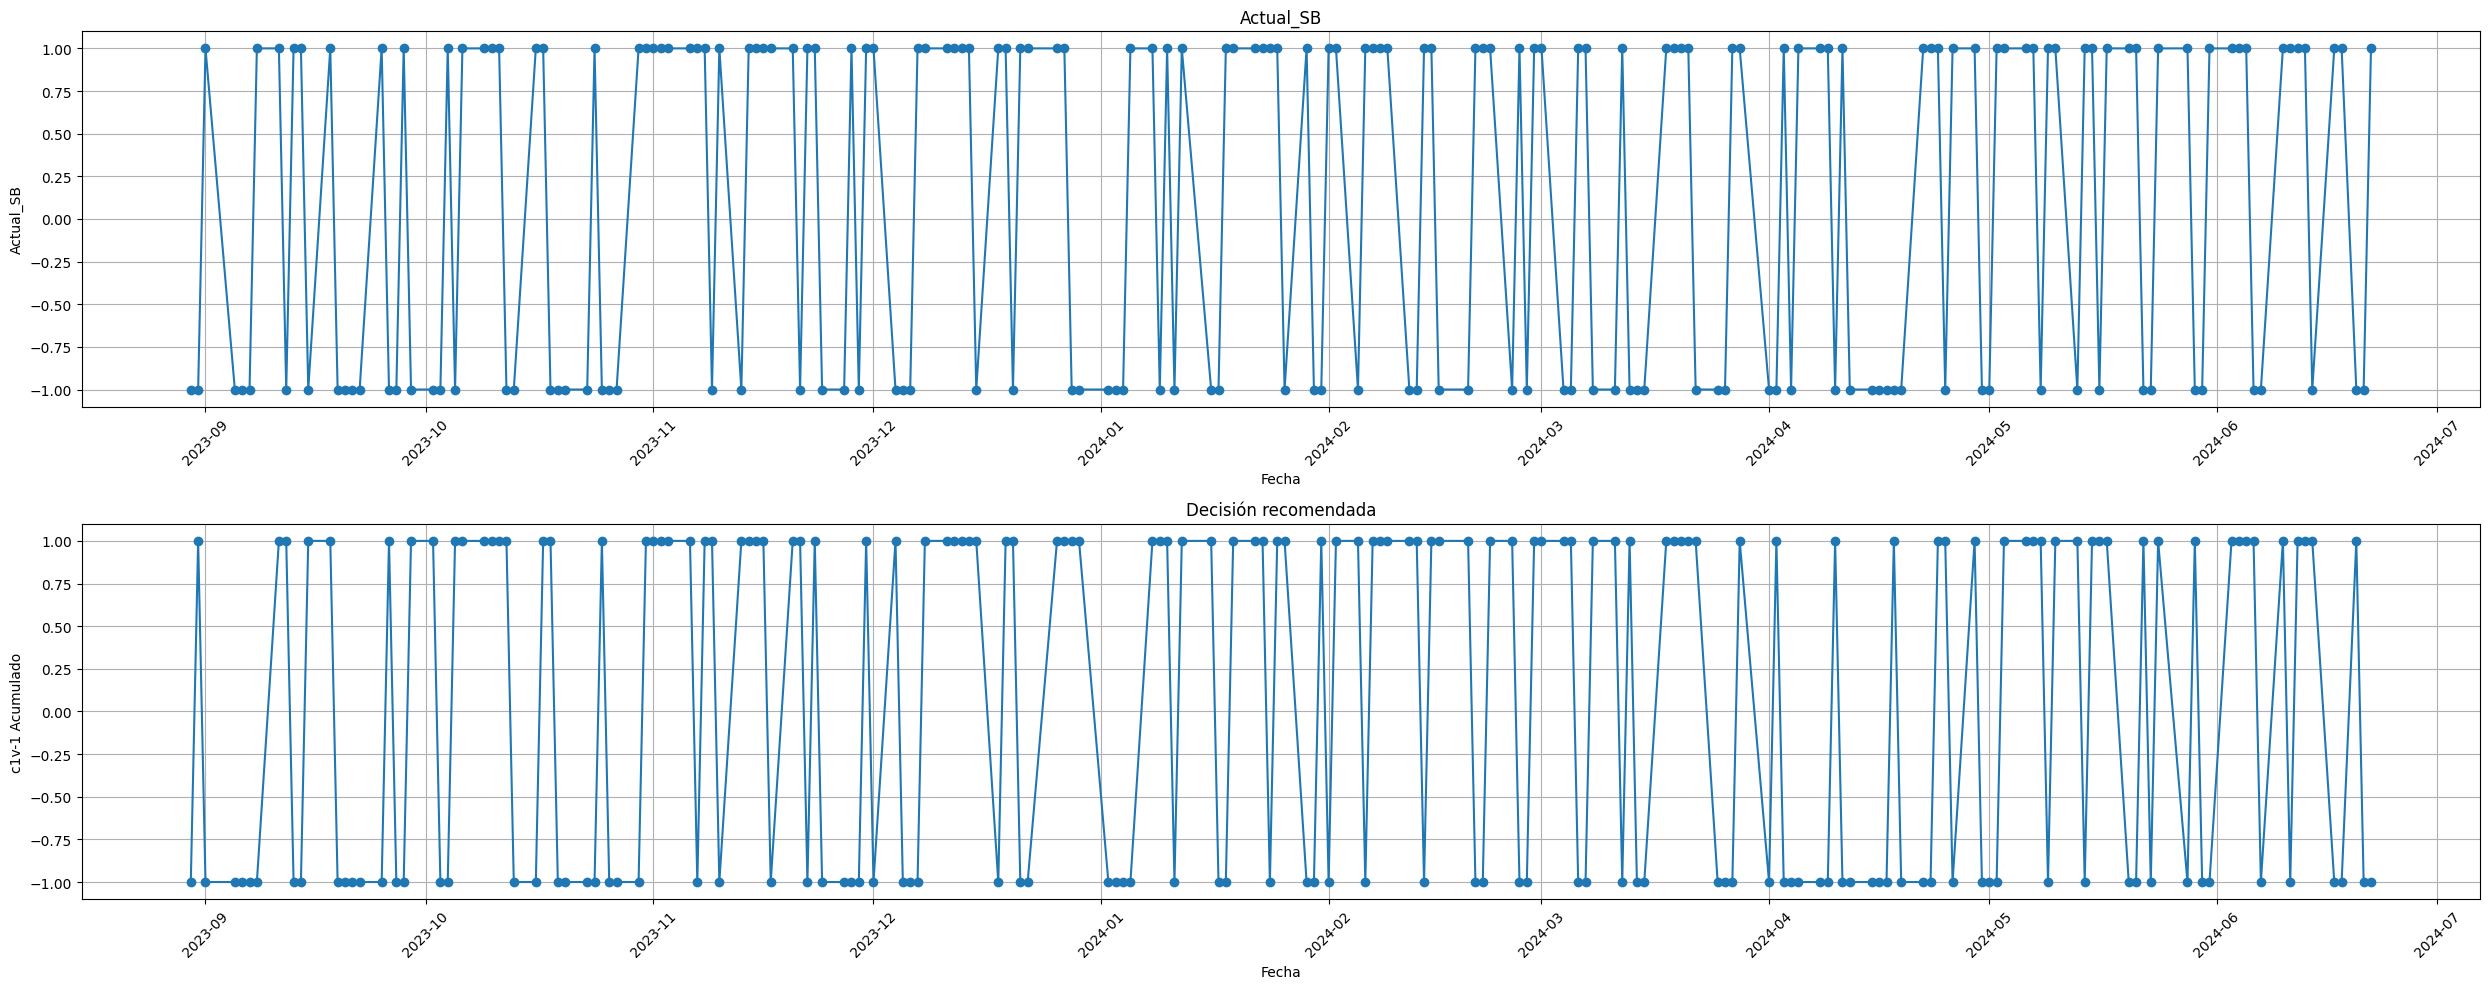

In [21]:
# Crear una figura con tres subplots (3 filas, 1 columna)
fig, axes = plt.subplots(2, 1, figsize=(25, 10))

# Graficar el acumulado de 'Actual_SB' por fecha
axes[0].plot(results_df.index, results_df['Actual_SB'], marker='o', linestyle='-')
axes[0].set_title('Actual_SB')
axes[0].set_xlabel('Fecha')
axes[0].set_ylabel('Actual_SB')
axes[0].grid(True)
axes[0].tick_params(axis='x', rotation=45)

# Graficar el acumulado de 'c1v-1' por fecha
axes[1].plot(results_df.index, results_df['c1v-1'], marker='o', linestyle='-')
axes[1].set_title('Decisión recomendada')
axes[1].set_xlabel('Fecha')
axes[1].set_ylabel('c1v-1 Acumulado')
axes[1].grid(True)
axes[1].tick_params(axis='x', rotation=45)

# Ajustar automáticamente los parámetros de la subtrama para dar espacio al diseño
plt.tight_layout()

# Mostrar la figura
plt.show()

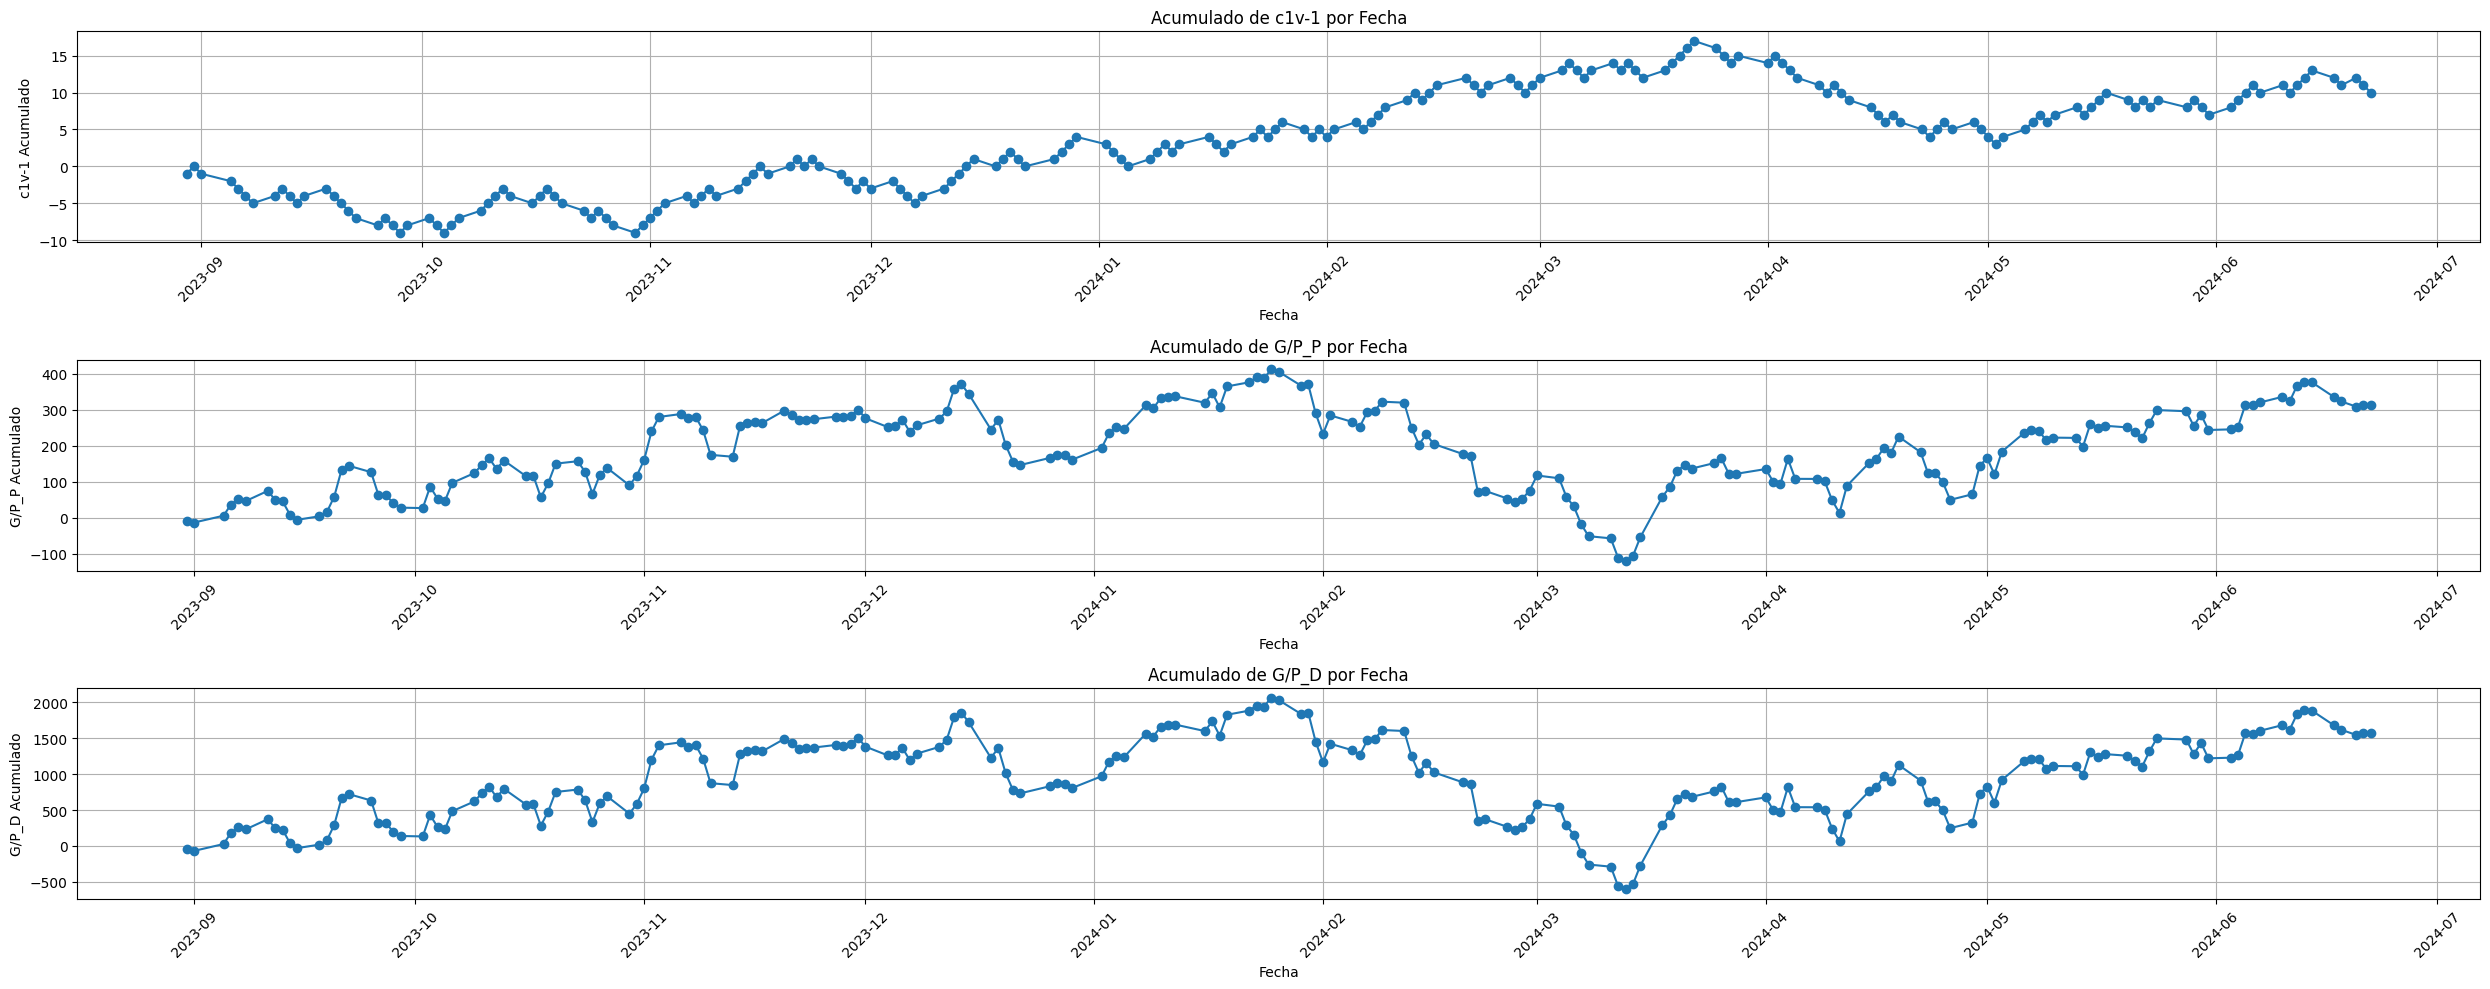

In [22]:
# Calcular la suma acumulativa
results_df['c1v-1_acumulado'] = results_df['c1v-1'].cumsum()
results_df['G/P_P_acumulado'] = results_df['G/P_P'].cumsum()
results_df['G/P_D_acumulado'] = results_df['G/P_D'].cumsum()

# Crear una figura con tres subplots (3 filas, 1 columna)
fig, axes = plt.subplots(3, 1, figsize=(25, 10))

# Graficar el acumulado de 'G/P_P' por fecha
axes[0].plot(results_df.index, results_df['c1v-1_acumulado'], marker='o', linestyle='-')
axes[0].set_title('Acumulado de c1v-1 por Fecha')
axes[0].set_xlabel('Fecha')
axes[0].set_ylabel('c1v-1 Acumulado')
axes[0].grid(True)
axes[0].tick_params(axis='x', rotation=45)

# Graficar el acumulado de 'G/P_P' por fecha
axes[1].plot(results_df.index, results_df['G/P_P_acumulado'], marker='o', linestyle='-')
axes[1].set_title('Acumulado de G/P_P por Fecha')
axes[1].set_xlabel('Fecha')
axes[1].set_ylabel('G/P_P Acumulado')
axes[1].grid(True)
axes[1].tick_params(axis='x', rotation=45)

# Graficar el acumulado de 'G/P_D' por fecha
axes[2].plot(results_df.index, results_df['G/P_D_acumulado'], marker='o', linestyle='-')
axes[2].set_title('Acumulado de G/P_D por Fecha')
axes[2].set_xlabel('Fecha')
axes[2].set_ylabel('G/P_D Acumulado')
axes[2].grid(True)
axes[2].tick_params(axis='x', rotation=45)

# Ajustar automáticamente los parámetros de la subtrama para dar espacio al diseño
plt.tight_layout()

# Mostrar la figura
plt.show()


In [23]:
results_df.describe ()

Actual    Predicted  DifferenceP       c1v-1  DifferenceA  \
count   206.000000   206.000000   205.000000  206.000000   205.000000   
mean   4860.749711  4860.600098     4.700572    0.048544     4.622635   
std     373.207909   372.491211    46.713234    1.001254    35.411341   
min    4137.750000  4102.713867  -199.766113   -1.000000   -80.500000   
25%    4516.812500  4541.840210   -18.500000   -1.000000   -14.250000   
50%    4907.125000  4936.345703     2.441895    1.000000     3.500000   
75%    5192.250000  5195.695679    28.984375    1.000000    26.500000   
max    5491.000000  5464.455078   173.068848    1.000000   113.080078   

        Actual_SB       G/P_P       G/P_D  c1v-1_acumulado  G/P_P_acumulado  \
count  206.000000  205.000000  205.000000       206.000000       205.000000   
mean     0.116505    1.532000    7.660001         3.567961       186.768760   
std      0.995610   35.680219  178.401095         6.959306       115.530497   
min     -1.000000 -101.500000 -507.500000        -9.000000      -121.209961   
25%     -1.000000  -18.000000  -90.000000        -3.000000       100.450195   
50%      1.000000    1.000000    5.000000         4.000000       183.700195   
75%      1.000000   20.500000  102.500000        10.000000       276.750000   
max      1.000000  113.080078  565.400391        17.000000       413.040039   

       G/P_D_acumulado  
count       205.000000  
mean        933.843798  
std         577.652487  
min        -606.049805  
25%         502.250977  
50%         918.500977  
75%        1383.750000  
max        2065.200195

In [24]:
csv_path = '/content/drive/My Drive/UTN/2024/202401/1_Investigacion/2024/IA_FIN_5_ANOS/Fuentes/Articulos/3/20240621_salida_v81.csv'  # Define la ruta en Google Drive.

results_df.to_csv(csv_path, index=True)  # Guarda el DataFrame como CSV en la ruta especificada.

In [25]:
df = results_df

# Calculando los retornos logarítmicos de las predicciones
df['log_returns'] = np.log(df['Predicted'] / df['Predicted'].shift(1))

# Eliminar cualquier NaN que pueda haber surgido del cálculo de los retornos
df.dropna(inplace=True)

# Calcular la desviación estándar de los retornos logarítmicos
volatilidad = df['log_returns'].std()

# La volatilidad anualizada se puede calcular asumiendo un número de periodos por año (por ejemplo, días de operación en el mercado)
dias_operacion = 252  # típicamente los días de operación de un mercado de valores
volatilidad_anualizada = volatilidad * np.sqrt(dias_operacion)

print(f"Volatilidad diaria: {volatilidad}")
print(f"Volatilidad anualizada: {volatilidad_anualizada}")


Volatilidad diaria: 0.009748365730047226
Volatilidad anualizada: 0.15475050846605745


In [26]:
# Define el número de días que quieres extraer
d = 6

# Extraer las últimas 'd' filas del DataFrame, incluyendo el índice de fecha
test_data = df[['Actual', 'Predicted']].tail(d)
test_data

Actual    Predicted
2024-06-14  5437.500000  5455.508789
2024-06-17  5478.500000  5453.943848
2024-06-18  5491.000000  5435.863770
2024-06-20  5476.750000  5464.455078
2024-06-21  5471.890137  5454.848145
2024-06-22  5471.890137  5450.222168

In [27]:
sigma = volatilidad  # Ajusta este valor según tus datos o análisis
N = 5000  # Número de simulaciones
T = d  # Simular 5 días adelante

# Función para realizar simulación de Montecarlo
def montecarlo_simulation(start_price, sigma, N, T):
    prices = np.zeros((N, T+1))
    prices[:, 0] = start_price
    for t in range(1, T+1):
        z = np.random.standard_normal(N)
        prices[:, t] = prices[:, t-1] * np.exp(-0.5 * sigma**2 + sigma * z)
    return prices

# Crear una columna en test_data para almacenar los resultados de Monte Carlo
test_data['MonteCarloResults'] = None
test_data['MeanMC'] = None

for index, row in test_data.iterrows():
    mc_results = montecarlo_simulation(row['Predicted'], sigma, N, T)
    test_data.at[index, 'MonteCarloResults'] = mc_results[:, -1]  # Guardar solo el último día de cada simulación
    test_data.at[index, 'MeanMC'] = np.mean(mc_results[:, -1])

print(test_data)

                 Actual    Predicted  \
2024-06-14  5437.500000  5455.508789   
2024-06-17  5478.500000  5453.943848   
2024-06-18  5491.000000  5435.863770   
2024-06-20  5476.750000  5464.455078   
2024-06-21  5471.890137  5454.848145   
2024-06-22  5471.890137  5450.222168   

                                            MonteCarloResults       MeanMC  
2024-06-14  [5356.433769900226, 5286.554822896916, 5549.97...  5456.075739  
2024-06-17  [5569.80718488599, 5342.515940114614, 5390.497...  5455.208547  
2024-06-18  [5537.466677167962, 5389.860401052808, 5355.75...  5440.413714  
2024-06-20  [5405.082350578853, 5170.596016589111, 5534.55...  5463.715542  
2024-06-21  [5537.912430980781, 5643.644992003415, 5665.71...  5458.102577  
2024-06-22  [5468.289477325582, 5210.774012369426, 5417.15...  5448.891557  


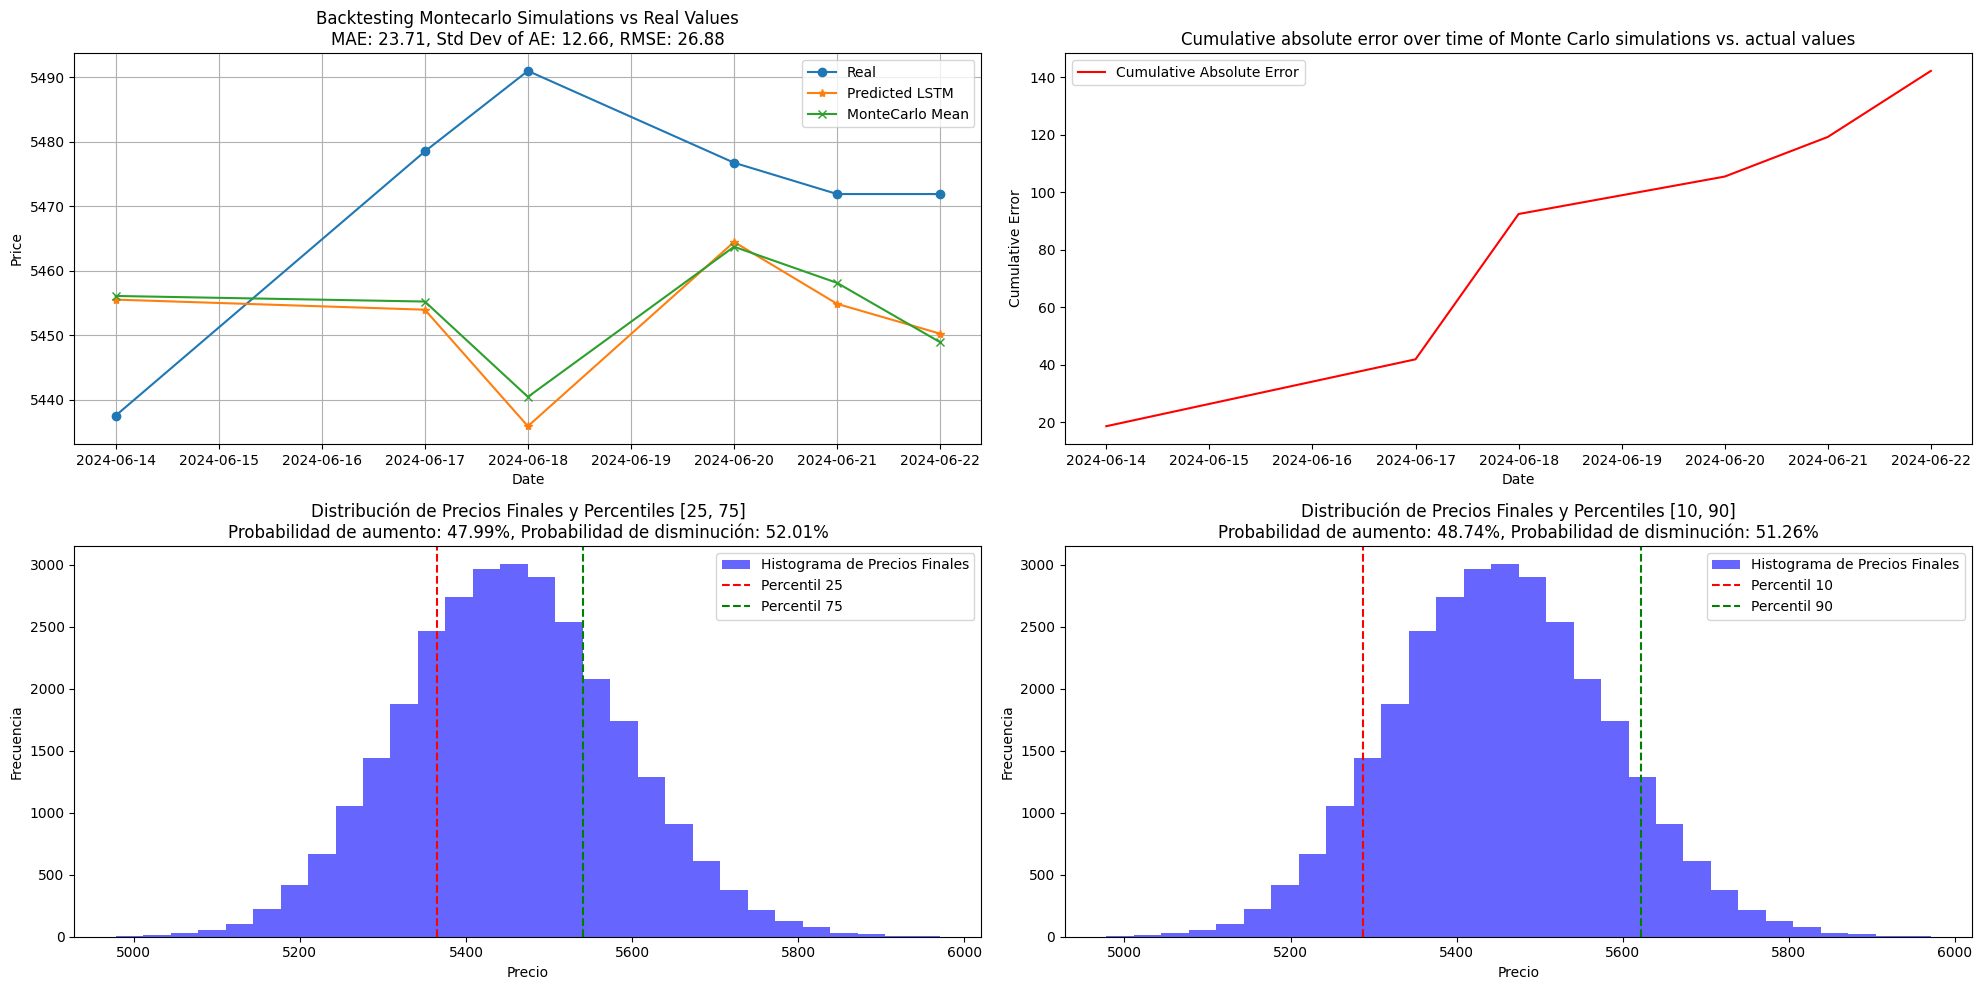

In [28]:
# Calculando errores
mae = mean_absolute_error(test_data['Actual'], test_data['MeanMC'])
mse = np.sqrt(mean_squared_error(test_data['Actual'], test_data['MeanMC']))

# Calculando la desviación estándar de los errores absolutos
errors = np.abs(test_data['Actual'] - test_data['MeanMC'])
std_dev = np.std(errors)

# Configuración de tres gráficos lado a lado
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

# Visualización de resultados en el primer gráfico
ax1.plot(test_data.index, test_data['Actual'], label='Real', marker='o')
ax1.plot(test_data.index, test_data['Predicted'], label='Predicted LSTM', marker='*')
ax1.plot(test_data.index, test_data['MeanMC'], label='MonteCarlo Mean', marker='x')
ax1.legend()
ax1.set_title('Backtesting Montecarlo Simulations vs Real Values\n' +
              f"MAE: {mae:.2f}, Std Dev of AE: {std_dev:.2f}, RMSE: {mse:.2f}")
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax1.grid(True)

# Visualización de resultados en el segundo gráfico
#cumulative_absolute_error = np.cumsum(np.abs(test_data['Actual'] - test_data['Predicted']))
cumulative_absolute_error = np.cumsum(np.abs(test_data['Actual'] - test_data['MeanMC']))
ax2.plot(test_data.index, cumulative_absolute_error, label='Cumulative Absolute Error', color='red')
ax2.set_title('Cumulative absolute error over time of Monte Carlo simulations vs. actual values')
ax2.set_xlabel('Date')
ax2.set_ylabel('Cumulative Error')
ax2.legend()

# Cálculo y visualización de percentiles [25, 75] en el tercer gráfico
prices = np.concatenate(test_data['MonteCarloResults'].values)
final_prices = prices
lower_bound, upper_bound = np.percentile(final_prices, [25, 75])
filtered_prices = final_prices[(final_prices >= lower_bound) & (final_prices <= upper_bound)]
prob_increase_filtered = np.mean(filtered_prices > test_data['Predicted'].iloc[0])
prob_decrease_filtered = np.mean(filtered_prices < test_data['Predicted'].iloc[0])

ax3.hist(final_prices, bins=30, alpha=0.6, color='blue', label='Histograma de Precios Finales')
ax3.axvline(x=lower_bound, color='red', linestyle='dashed', linewidth=1.5, label='Percentil 25')
ax3.axvline(x=upper_bound, color='green', linestyle='dashed', linewidth=1.5, label='Percentil 75')
ax3.set_title('Distribución de Precios Finales y Percentiles [25, 75]\n' +
              f"Probabilidad de aumento: {prob_increase_filtered * 100:.2f}%, " +
              f"Probabilidad de disminución: {prob_decrease_filtered * 100:.2f}%")
ax3.set_xlabel('Precio')
ax3.set_ylabel('Frecuencia')
ax3.legend()

# Cálculo y visualización de percentiles [10, 90] en el cuarto gráfico
lower_bound_wide, upper_bound_wide = np.percentile(final_prices, [10, 90])
filtered_prices_wide = final_prices[(final_prices >= lower_bound_wide) & (final_prices <= upper_bound_wide)]
prob_increase_wide = np.mean(filtered_prices_wide > test_data['Predicted'].iloc[0])
prob_decrease_wide = np.mean(filtered_prices_wide < test_data['Predicted'].iloc[0])

ax4.hist(final_prices, bins=30, alpha=0.6, color='blue', label='Histograma de Precios Finales')
ax4.axvline(x=lower_bound_wide, color='red', linestyle='dashed', linewidth=1.5, label='Percentil 10')
ax4.axvline(x=upper_bound_wide, color='green', linestyle='dashed', linewidth=1.5, label='Percentil 90')
ax4.set_title('Distribución de Precios Finales y Percentiles [10, 90]\n' +
              f"Probabilidad de aumento: {prob_increase_wide * 100:.2f}%, " +
              f"Probabilidad de disminución: {prob_decrease_wide * 100:.2f}%")
ax4.set_xlabel('Precio')
ax4.set_ylabel('Frecuencia')
ax4.legend()

# Mostrar todos los gráficos
plt.tight_layout()
plt.show()